**Finance and Structuring for Data Science**

*Final project*

Sushant, Anna & Sofia 

**Problem Statement**

NN Trading Strategy for SPY (S&P 500 ETF) 

The prices of single name stocks are subject to “gaping” i.e. sudden major moves - SVB, First Republic Banks are cases in point. 
Therefore the project is based on SPY (S&P 500) ETF that is less prone to such big moves 
Consider a profit taking level of Δ e.g.  Δ = 0.01 = 1%. 
The objective is to estimate the probability that High ≥ (1.01) Open or in general High ≥ (1 + Δ ). 
The trading strategy is to enter a trade if this probability is > p  say p = 60% 

The input are the following variables for the previous n days:

*   Open
*   Close
*   High
*   Low
*   Volume

We start with n=3. 
	
The project is to use NN to solve this classification problem and use the softmax activation function to estimate the probability of making a profit of Δ.

Approach -

**Data Preprocessing**: Load the Yfinance dataset and preprocess the data by creating input features and splitting the data into training and validation sets.

**Model Creation**: Create a NN model with the best architecture, using binary cross-entropy loss and softmax activation functions.

**Model Training**: Train the model using the training data, monitoring the validation loss and accuracy to prevent overfitting.

**Model Evaluation**: Evaluate the model's performance on the validation data, using various metrics such as accuracy, precision, recall, and F1-score.

**Trading Strategy**: Use the trained model to enter a trade if the predicted probability of making a profit is greater than a certain threshold.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Import libraries
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score , f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from keras.regularizers import l1, l2

**Data Preprocessing**

In [ ]:
np.random.seed(334)
tf.random.set_seed(334)

# Define the ticker symbol and start and end dates for the data
ticker_symbol = 'SPY'
start_date = '2000-01-01'
end_date = '2023-05-05'

# Download the historical data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Keep only the columns we need
data = data[['Open', 'Close', 'High', 'Low', 'Volume']]

# Define the profit taking level (Delta)
delta = 0.01

# Create a new column for the target variable (profit or loss)
data['Target'] = np.where(data['High'] >= (1 + delta) * data['Open'], 1, 0)

# Drop any rows with missing values
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


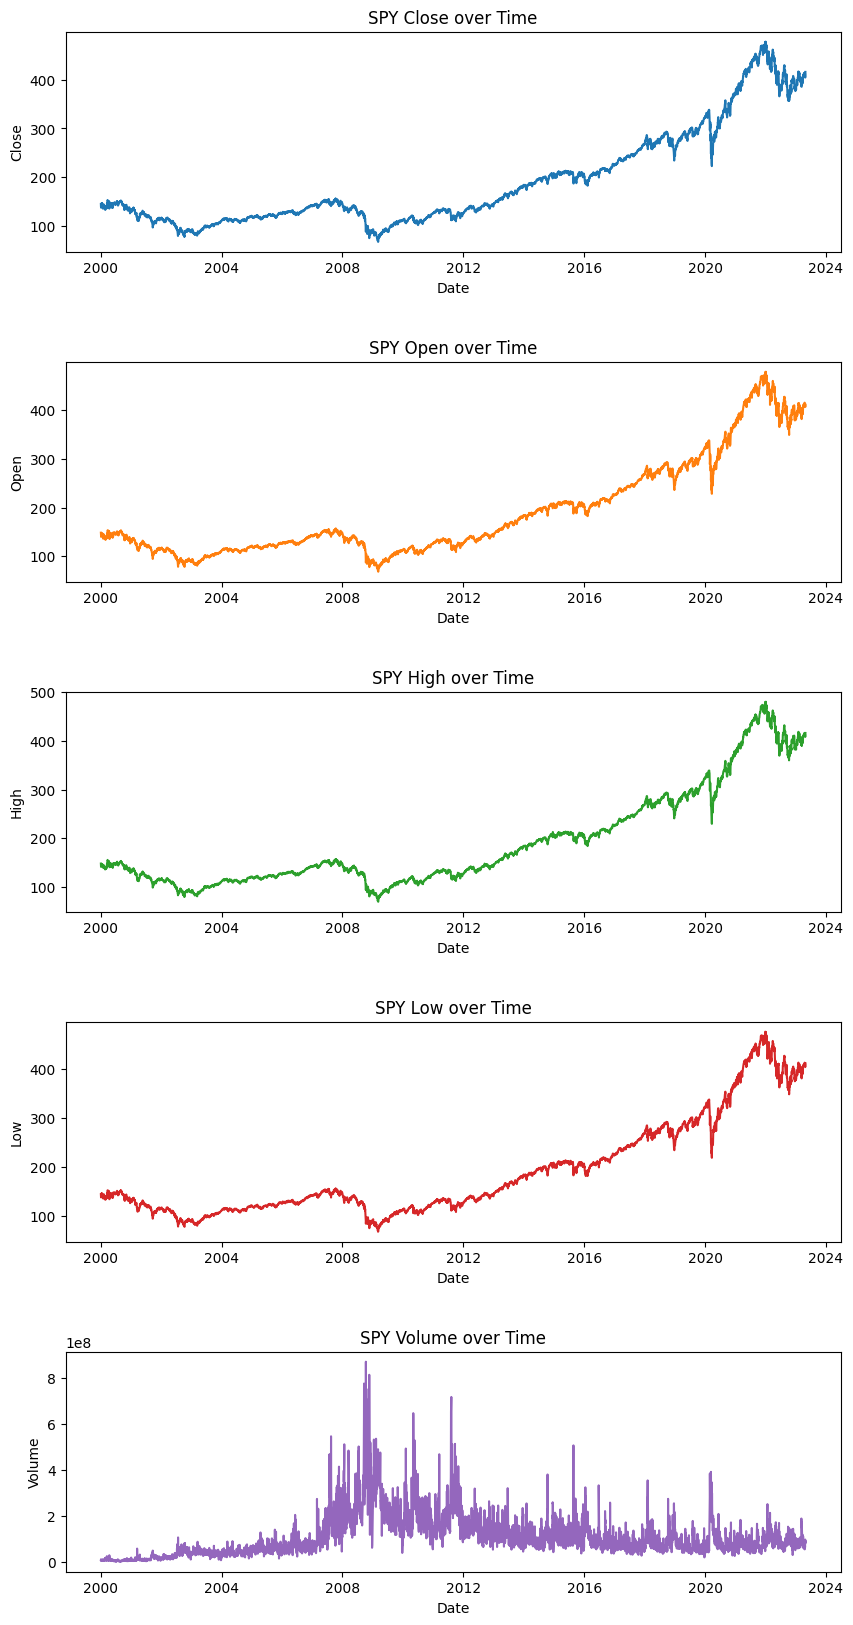

In [ ]:
# Define the attributes to be plotted
attributes = ['Close', 'Open', 'High', 'Low', 'Volume']

# Create a subplot with one column and a number of rows equal to the number of attributes
fig, axs = plt.subplots(nrows=len(attributes), ncols=1, figsize=(10,20))
# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.5)

# Loop through each attribute and create a line plot for it
for i, attribute in enumerate(attributes):
    # Plot the attribute values over time using a unique color for each attribute
    axs[i].plot(data[attribute], color='C'+str(i))
    # Set the title of the subplot to the attribute's name
    axs[i].set_title('SPY ' + attribute + ' over Time')
    # Label the x-axis as 'Date'
    axs[i].set_xlabel('Date')
    # Label the y-axis with the attribute's name
    axs[i].set_ylabel(attribute)

# Save the generated figure as a .png file
plt.savefig('SPY_attributes.png')
# Display the figure
plt.show()

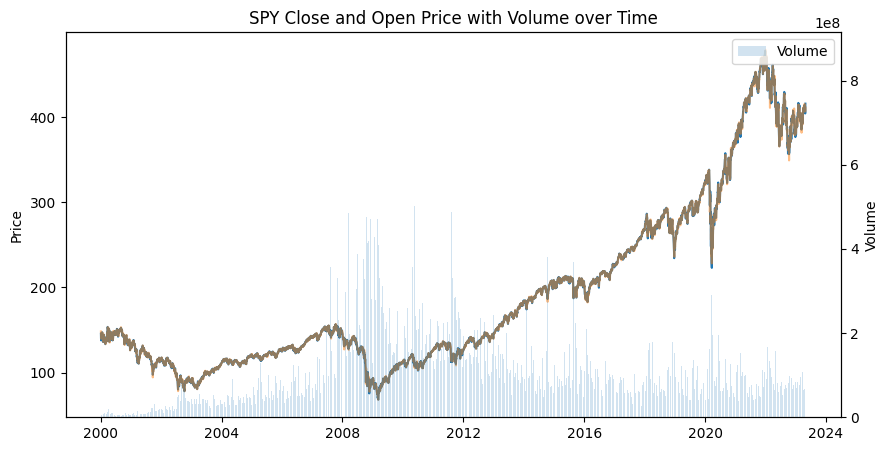

In [ ]:
# Create a figure with a custom size
plt.figure(figsize=(10,5))

# Plot the 'Close' and 'Open' prices using different line styles and transparency
plt.plot(data['Close'], label='Close')
plt.plot(data['Open'], alpha=0.5, label='Open')

# Label the y-axis as 'Price'
plt.ylabel('Price')

# Create a second y-axis for the volume data
plt.twinx()

# Plot the 'Volume' data as a bar chart with custom transparency and width
plt.bar(data.index, data['Volume'], alpha=0.2, width=1, label='Volume')

# Label the second y-axis as 'Volume'
plt.ylabel('Volume')

# Add a legend to the plot
plt.legend()

# Set the title of the plot
plt.title('SPY Close and Open Price with Volume over Time')

# Label the x-axis as 'Date'
plt.xlabel('Date')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)

# Separate the features and target variable
X = data.iloc[:, :-1]
y = data['Target']

# Apply SMOTE to balance the dataset
X_smote, y_smote = smote.fit_resample(X, y)

# Combine the balanced features and target variable back into a single DataFrame
data = pd.concat([X_smote, y_smote], axis=1)

In [ ]:
# Use K-Fold cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def create_rolling_windows(data, window_size):
    # Initialize an empty list to store the rolling windows
    windows = []

    # Iterate through the data and create rolling windows of the specified size
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])

    # Convert the list of windows into a NumPy array and return it
    return np.array(windows)

In [ ]:
window_sizes = [3, 50, 100, 1000]

**NN architecture**

Training and evaluating with window size: 3


Epoch 1/100
50/50 [==============================] - 18s 41ms/step - loss: 0.6075 - accuracy: 0.7057 - val_loss: 0.6099 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 1s 18ms/step - loss: 0.5424 - accuracy: 0.7576 - val_loss: 0.5822 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 0.5288 - accuracy: 0.7519 - val_loss: 0.5617 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 1s 18ms/step - loss: 0.5220 - accuracy: 0.7513 - val_loss: 0.5519 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 0.5260 - accuracy: 0.7608 - val_loss: 0.5633 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 1s 22ms/step - loss: 0.5299 - accuracy: 0.7551 - val_loss: 0.5456 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 1s 19ms/step - l

Epoch 1/100
99/99 [==============================] - 18s 66ms/step - loss: 0.5808 - accuracy: 0.7407 - val_loss: 0.5341 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 2/100
99/99 [==============================] - 3s 27ms/step - loss: 0.5314 - accuracy: 0.7616 - val_loss: 0.5217 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 3/100
99/99 [==============================] - 2s 21ms/step - loss: 0.5235 - accuracy: 0.7629 - val_loss: 0.3934 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 4/100
99/99 [==============================] - 3s 26ms/step - loss: 0.5185 - accuracy: 0.7676 - val_loss: 0.3544 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 5/100
99/99 [==============================] - 3s 32ms/step - loss: 0.5084 - accuracy: 0.7683 - val_loss: 0.3165 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 6/100
99/99 [==============================] - 3s 32ms/step - loss: 0.5007 - accuracy: 0.7702 - val_loss: 0.4160 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 7/100
99/99 [==============================] - 2s 23ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
149/149 [==============================] - 16s 20ms/step - loss: 0.5097 - accuracy: 0.7967 - val_loss: 0.6862 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 2/100
149/149 [==============================] - 2s 16ms/step - loss: 0.4546 - accuracy: 0.8210 - val_loss: 0.7159 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 3/100
149/149 [==============================] - 3s 17ms/step - loss: 0.4448 - accuracy: 0.8198 - val_loss: 0.7164 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 4/100
149/149 [==============================] - 2s 13ms/step - loss: 0.4309 - accuracy: 0.8219 - val_loss: 0.7226 - val_accuracy: 0.5603 - lr: 0.0010
Epoch 5/100
149/149 [==============================] - 2s 13ms/step - loss: 0.4205 - accuracy: 0.8212 - val_loss: 1.0375 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 6/100
149/149 [==============================] - 2s 12ms/step - loss: 0.4208 - accuracy: 0.8164 - val_loss: 0.9669 - val_accuracy: 0.5603 - lr: 0.0010
Epoch 7/100
149/149 [==============================] - 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
198/198 [==============================] - 11s 22ms/step - loss: 0.5466 - accuracy: 0.7510 - val_loss: 0.9729 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 3s 13ms/step - loss: 0.5031 - accuracy: 0.7728 - val_loss: 0.9371 - val_accuracy: 0.1015 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 2s 12ms/step - loss: 0.4803 - accuracy: 0.7899 - val_loss: 0.7847 - val_accuracy: 0.5698 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 2s 12ms/step - loss: 0.4648 - accuracy: 0.7986 - val_loss: 0.4296 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 3s 13ms/step - loss: 0.4403 - accuracy: 0.8108 - val_loss: 0.2280 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 3s 16ms/step - loss: 0.4335 - accuracy: 0.8134 - val_loss: 0.3431 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 7/100
198/198 [==============================] 

Epoch 1/100
247/247 [==============================] - 13s 17ms/step - loss: 0.5759 - accuracy: 0.7148 - val_loss: 0.5758 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 3s 12ms/step - loss: 0.4288 - accuracy: 0.8095 - val_loss: 0.1765 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 3s 12ms/step - loss: 0.4038 - accuracy: 0.8236 - val_loss: 0.0666 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 4s 15ms/step - loss: 0.3840 - accuracy: 0.8335 - val_loss: 0.0932 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 3s 11ms/step - loss: 0.3723 - accuracy: 0.8355 - val_loss: 0.1512 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 3s 12ms/step - loss: 0.3726 - accuracy: 0.8336 - val_loss: 0.0719 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 3s

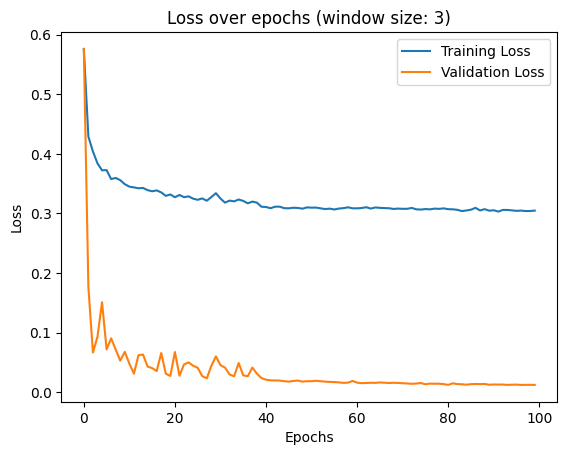

Training and evaluating with window size: 50


Epoch 1/100
48/48 [==============================] - 10s 66ms/step - loss: 0.6585 - accuracy: 0.6941 - val_loss: 0.5522 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 1s 21ms/step - loss: 0.5859 - accuracy: 0.7384 - val_loss: 0.5582 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 1s 22ms/step - loss: 0.5649 - accuracy: 0.7449 - val_loss: 0.6248 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 1s 21ms/step - loss: 0.5757 - accuracy: 0.7449 - val_loss: 0.5471 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 1s 21ms/step - loss: 0.5504 - accuracy: 0.7443 - val_loss: 0.5661 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 1s 22ms/step - loss: 0.5610 - accuracy: 0.7482 - val_loss: 0.5589 - val_accuracy: 0.7554 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 1s 22ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
98/98 [==============================] - 12s 34ms/step - loss: 0.6504 - accuracy: 0.7159 - val_loss: 0.4331 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - 2s 19ms/step - loss: 0.5775 - accuracy: 0.7539 - val_loss: 0.3466 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - 3s 27ms/step - loss: 0.5594 - accuracy: 0.7635 - val_loss: 0.2689 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - 3s 29ms/step - loss: 0.5454 - accuracy: 0.7609 - val_loss: 0.2870 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - 2s 19ms/step - loss: 0.5444 - accuracy: 0.7619 - val_loss: 0.3748 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - 2s 23ms/step - loss: 0.5277 - accuracy: 0.7667 - val_loss: 0.3089 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 7/100
98/98 [==============================] - 3s 28ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
147/147 [==============================] - 12s 29ms/step - loss: 0.5432 - accuracy: 0.7873 - val_loss: 0.8623 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 3s 18ms/step - loss: 0.4824 - accuracy: 0.8133 - val_loss: 1.0976 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 3s 23ms/step - loss: 0.4735 - accuracy: 0.8141 - val_loss: 0.8794 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 3s 18ms/step - loss: 0.4490 - accuracy: 0.8194 - val_loss: 0.9415 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 5/100
147/147 [==============================] - 3s 18ms/step - loss: 0.4434 - accuracy: 0.8207 - val_loss: 0.7912 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 6/100
147/147 [==============================] - 3s 18ms/step - loss: 0.4286 - accuracy: 0.8209 - val_loss: 0.8380 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 7/100
147/147 [==============================] - 3s

Epoch 1/100
196/196 [==============================] - 12s 26ms/step - loss: 0.5725 - accuracy: 0.7608 - val_loss: 0.0973 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 4s 18ms/step - loss: 0.4614 - accuracy: 0.8196 - val_loss: 0.1028 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 3s 17ms/step - loss: 0.4314 - accuracy: 0.8220 - val_loss: 0.2699 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 3s 17ms/step - loss: 0.4497 - accuracy: 0.8199 - val_loss: 0.1270 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 4s 21ms/step - loss: 0.4201 - accuracy: 0.8255 - val_loss: 0.1155 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 6/100
196/196 [==============================] - 3s 17ms/step - loss: 0.4177 - accuracy: 0.8255 - val_loss: 0.0216 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 7/100
196/196 [==============================] - 3s

Epoch 1/100
246/246 [==============================] - 14s 24ms/step - loss: 0.4584 - accuracy: 0.8266 - val_loss: 0.0068 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
246/246 [==============================] - 4s 18ms/step - loss: 0.3662 - accuracy: 0.8548 - val_loss: 0.4642 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 3/100
246/246 [==============================] - 4s 17ms/step - loss: 0.3780 - accuracy: 0.8460 - val_loss: 0.0050 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 4/100
246/246 [==============================] - 5s 20ms/step - loss: 0.3420 - accuracy: 0.8602 - val_loss: 1.4534e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
246/246 [==============================] - 4s 18ms/step - loss: 0.3267 - accuracy: 0.8587 - val_loss: 6.3717e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
246/246 [==============================] - 4s 17ms/step - loss: 0.3285 - accuracy: 0.8601 - val_loss: 4.3311e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
246/246 [========================

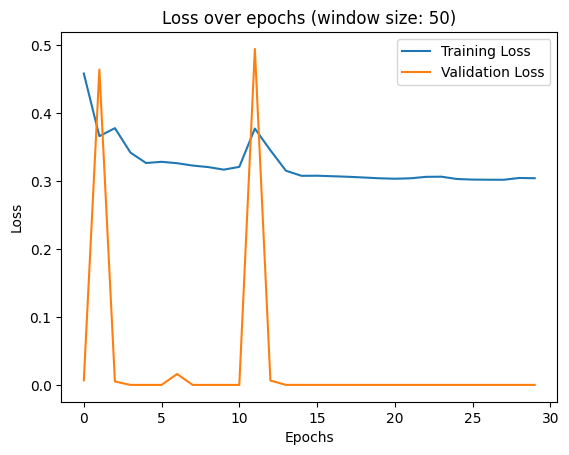

Training and evaluating with window size: 100


Epoch 1/100
47/47 [==============================] - 11s 65ms/step - loss: 0.6265 - accuracy: 0.7283 - val_loss: 0.5871 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 1s 28ms/step - loss: 0.5706 - accuracy: 0.7431 - val_loss: 0.6168 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 1s 28ms/step - loss: 0.5603 - accuracy: 0.7465 - val_loss: 0.5483 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 2s 34ms/step - loss: 0.5463 - accuracy: 0.7505 - val_loss: 0.5952 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 1s 29ms/step - loss: 0.5505 - accuracy: 0.7498 - val_loss: 0.5459 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 2s 34ms/step - loss: 0.5354 - accuracy: 0.7559 - val_loss: 0.5589 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 2s 38ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
96/96 [==============================] - 13s 40ms/step - loss: 0.6766 - accuracy: 0.7018 - val_loss: 0.4397 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 3s 27ms/step - loss: 0.5887 - accuracy: 0.7479 - val_loss: 0.3503 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 3s 34ms/step - loss: 0.5504 - accuracy: 0.7622 - val_loss: 0.3088 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 3s 27ms/step - loss: 0.5369 - accuracy: 0.7652 - val_loss: 0.2934 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 2s 24ms/step - loss: 0.5286 - accuracy: 0.7730 - val_loss: 0.2749 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 2s 24ms/step - loss: 0.5157 - accuracy: 0.7796 - val_loss: 0.2729 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 2s 24ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
146/146 [==============================] - 14s 44ms/step - loss: 0.5341 - accuracy: 0.7979 - val_loss: 0.9343 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 2/100
146/146 [==============================] - 4s 27ms/step - loss: 0.4757 - accuracy: 0.8199 - val_loss: 0.7314 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 3/100
146/146 [==============================] - 3s 23ms/step - loss: 0.4470 - accuracy: 0.8186 - val_loss: 0.8862 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 4/100
146/146 [==============================] - 3s 23ms/step - loss: 0.4424 - accuracy: 0.8225 - val_loss: 1.1615 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 5/100
146/146 [==============================] - 4s 30ms/step - loss: 0.4363 - accuracy: 0.8229 - val_loss: 0.8589 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 6/100
146/146 [==============================] - 4s 24ms/step - loss: 0.4235 - accuracy: 0.8235 - val_loss: 1.2666 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 7/100
146/146 [==============================] - 4s

Epoch 1/100
195/195 [==============================] - 14s 34ms/step - loss: 0.5457 - accuracy: 0.7772 - val_loss: 0.2844 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 2/100
195/195 [==============================] - 5s 24ms/step - loss: 0.5232 - accuracy: 0.7723 - val_loss: 0.3940 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 3/100
195/195 [==============================] - 5s 24ms/step - loss: 0.4434 - accuracy: 0.8257 - val_loss: 0.0086 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 4/100
195/195 [==============================] - 5s 26ms/step - loss: 0.4576 - accuracy: 0.8082 - val_loss: 0.1421 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
195/195 [==============================] - 4s 22ms/step - loss: 0.4401 - accuracy: 0.8211 - val_loss: 0.0877 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 6/100
195/195 [==============================] - 5s 25ms/step - loss: 0.4223 - accuracy: 0.8270 - val_loss: 0.0770 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 7/100
195/195 [==============================] - 4s

Epoch 1/100
244/244 [==============================] - 16s 27ms/step - loss: 0.4367 - accuracy: 0.8316 - val_loss: 0.0225 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 2/100
244/244 [==============================] - 6s 25ms/step - loss: 0.3829 - accuracy: 0.8555 - val_loss: 3.4207e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
244/244 [==============================] - 5s 22ms/step - loss: 0.3430 - accuracy: 0.8616 - val_loss: 1.9520e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
244/244 [==============================] - 6s 23ms/step - loss: 0.3487 - accuracy: 0.8546 - val_loss: 0.0601 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 5/100
244/244 [==============================] - 5s 22ms/step - loss: 0.3484 - accuracy: 0.8606 - val_loss: 1.1148e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
244/244 [==============================] - 5s 22ms/step - loss: 0.3343 - accuracy: 0.8638 - val_loss: 2.9559e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
244/244 [====================

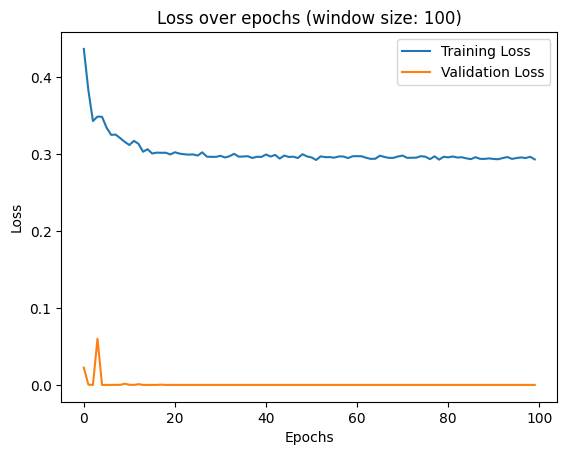

Training and evaluating with window size: 1000


Epoch 1/100
19/19 [==============================] - 12s 261ms/step - loss: 0.5797 - accuracy: 0.7599 - val_loss: 0.5440 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 3s 162ms/step - loss: 0.4534 - accuracy: 0.8868 - val_loss: 0.5013 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 3s 162ms/step - loss: 0.3973 - accuracy: 0.9057 - val_loss: 0.4942 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 3s 167ms/step - loss: 0.4010 - accuracy: 0.9125 - val_loss: 0.4996 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 3s 173ms/step - loss: 0.3969 - accuracy: 0.9005 - val_loss: 0.5143 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 3s 162ms/step - loss: 0.3507 - accuracy: 0.9039 - val_loss: 0.5000 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 7/100
19/19 [==============================] - 2s 130ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
68/68 [==============================] - 17s 120ms/step - loss: 0.6273 - accuracy: 0.7428 - val_loss: 0.3577 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 8s 119ms/step - loss: 0.5383 - accuracy: 0.7905 - val_loss: 0.3401 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 8s 111ms/step - loss: 0.5004 - accuracy: 0.7919 - val_loss: 0.2741 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 7s 110ms/step - loss: 0.4943 - accuracy: 0.7909 - val_loss: 0.2595 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 8s 112ms/step - loss: 0.4704 - accuracy: 0.8154 - val_loss: 0.2088 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 7s 109ms/step - loss: 0.4664 - accuracy: 0.8108 - val_loss: 0.2032 - val_accuracy: 0.9465 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 8s 119ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
117/117 [==============================] - 21s 118ms/step - loss: 0.4745 - accuracy: 0.8297 - val_loss: 1.1529 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 12s 106ms/step - loss: 0.4141 - accuracy: 0.8538 - val_loss: 1.3424 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 12s 102ms/step - loss: 0.3973 - accuracy: 0.8586 - val_loss: 1.5418 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 12s 102ms/step - loss: 0.3860 - accuracy: 0.8583 - val_loss: 1.7261 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 13s 107ms/step - loss: 0.3810 - accuracy: 0.8597 - val_loss: 1.7371 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 12s 102ms/step - loss: 0.3759 - accuracy: 0.8565 - val_loss: 1.6707 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 7/100
117/117 [=========================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
167/167 [==============================] - 27s 112ms/step - loss: 0.5382 - accuracy: 0.7788 - val_loss: 0.6994 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 2/100
167/167 [==============================] - 17s 104ms/step - loss: 0.5087 - accuracy: 0.7677 - val_loss: 1.8547 - val_accuracy: 0.0397 - lr: 0.0010
Epoch 3/100
167/167 [==============================] - 18s 107ms/step - loss: 0.4195 - accuracy: 0.8397 - val_loss: 0.0511 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
167/167 [==============================] - 18s 108ms/step - loss: 0.3795 - accuracy: 0.8445 - val_loss: 0.1211 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
167/167 [==============================] - 26s 153ms/step - loss: 0.3676 - accuracy: 0.8530 - val_loss: 0.0022 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
167/167 [==============================] - 19s 114ms/step - loss: 0.3982 - accuracy: 0.8457 - val_loss: 0.0222 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
167/167 [=========================

Epoch 1/100
216/216 [==============================] - 32s 109ms/step - loss: 0.4380 - accuracy: 0.8366 - val_loss: 0.0078 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
216/216 [==============================] - 22s 100ms/step - loss: 0.3103 - accuracy: 0.8839 - val_loss: 1.9172e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
216/216 [==============================] - 21s 100ms/step - loss: 0.2941 - accuracy: 0.8861 - val_loss: 4.5602e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
216/216 [==============================] - 21s 97ms/step - loss: 0.2903 - accuracy: 0.8864 - val_loss: 1.7379e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
216/216 [==============================] - 22s 103ms/step - loss: 0.2855 - accuracy: 0.8877 - val_loss: 1.2932e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
216/216 [==============================] - 22s 102ms/step - loss: 0.2817 - accuracy: 0.8872 - val_loss: 6.3842e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
216/216 [======

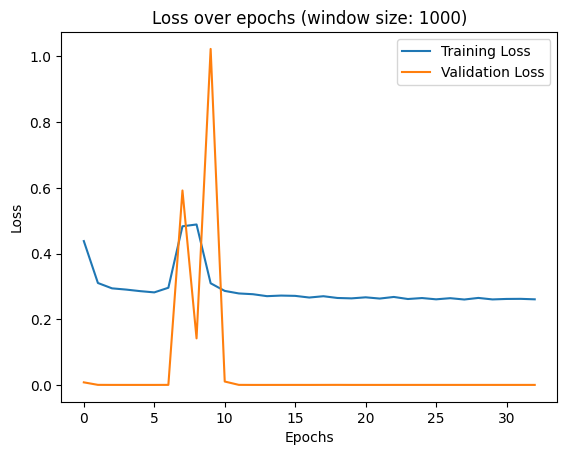

In [ ]:
# Record the starting time
start_time = datetime.datetime.now()

# Initialize a list to store results for all window sizes
results_all = []

# Iterate through different window sizes
for window_size in window_sizes:
    print(f"Training and evaluating with window size: {window_size}")

    # Initialize metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Perform time series cross-validation
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Convert the labels to categorical
        train_labels_cat = tf.keras.utils.to_categorical(train_data['Target'], num_classes=2)
        test_labels_cat = tf.keras.utils.to_categorical(test_data['Target'], num_classes=2)

        # Split the data into features and labels
        train_X = train_data.iloc[:, :-1]
        train_y = train_labels_cat
        test_X = test_data.iloc[:, :-1]
        test_y = test_labels_cat

        # Scale the input features using StandardScaler
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        # Create rolling windows
        train_X = create_rolling_windows(train_X, window_size)
        test_X = create_rolling_windows(test_X, window_size)

        # Adjust the labels to match the rolling windows
        train_y = train_y[window_size:]
        test_y = test_y[window_size:]

        # Define the input shape for the neural network
        n_features = 5  # Open, Close, High, Low, Volume
        input_shape = (None, n_features)  # Use all available previous days

        # Build the LSTM model
        inputs = Input(shape=input_shape)
        x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
        x = LSTM(128, activation='tanh', return_sequences=True)(x)
        x = LSTM(64, activation='tanh')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(2, activation='softmax')(x)

        # Compile the model
        model = Model(inputs=inputs, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(lr=0.001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Define callbacks for early stopping and learning rate reduction
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.00001)

        # Train the model
        history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), callbacks=[early_stopping, lr_scheduler])

        # Evaluate the model
        results = model.evaluate(test_X, test_y)

        # Define a threshold for classifying the output
        threshold = 0.5

        # Convert one-hot encoded test labels back to class labels
        test_labels = np.argmax(test_y, axis=1)

        # Get the predicted probabilities and convert them to class labels
        y_pred = model.predict(test_X)
        y_pred_classes = np.where(y_pred[:, 1] > threshold, 1, 0)

        # Calculate evaluation metrics for this fold
        accuracy = accuracy_score(test_labels, y_pred_classes)
        precision = precision_score(test_labels, y_pred_classes)
        recall = recall_score(test_labels, y_pred_classes)
        f1 = f1_score(test_labels, y_pred_classes)

        # Append metrics to respective lists
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Calculate the average metrics for this window size
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    # Store the results for this window size
    results_all.append([window_size, avg_accuracy, avg_precision, avg_recall, avg_f1])

    # Plot the training and validation loss for this window size
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss over epochs (window size: {window_size})')
    plt.legend()
    plt.show()

# Record the end time and calculate the time difference
end_time = datetime.datetime.now()
time_diff = end_time - start_time
minutes = time_diff.seconds // 60
hours = minutes // 60
seconds = time_diff.seconds % 60

# Print the time taken for the overall neural network model to run
print("Time taken for NN model to run overall :", hours, "hours,", minutes, "minutes, and", seconds, "seconds.")



In [ ]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(results_all, columns=['Window Size', 'Accuracy', 'Precision', 'Recall', 'F1'])
print(results_df)

   Window Size  Accuracy  Precision    Recall        F1
0            3  0.841244   0.514894  0.473559  0.491930
1           50  0.847220   0.569231  0.403202  0.406286
2          100  0.841650   0.600000  0.399797  0.401207
3         1000  0.782729   0.400000  0.400000  0.400000


# Prophet TS Forecasting

**CNN architecture**

In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the ticker symbol and date range for data retrieval
ticker_symbol = 'SPY'
start_date = '2000-01-01'
end_date = '2023-04-30'

# Download historical data using Yahoo Finance API
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate returns, log returns, and volatility
data['returns'] = data['Adj Close'].pct_change()
data['log_returns'] = np.log(1 + data['returns'])
data['volatility'] = data['log_returns'].rolling(window=3, min_periods=1).std() * np.sqrt(252)

# Remove missing values
data.dropna(inplace=True)

# Prepare the input features and target variable
X = data[['Open', 'Close', 'High', 'Low', 'Volume', 'volatility']].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = ((data['High'].shift(-1) / data['Open']) >= 1.01).astype(int)
y = y[:-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:-1], y, test_size=0.2, shuffle=False)

# Reshape the input data for 1D CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the 1D CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy
print('Test accuracy:', test_acc)

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
147/147 - 2s - loss: 0.5921 - accuracy: 0.7050 - 2s/epoch - 14ms/step
Epoch 2/100
147/147 - 0s - loss: 0.5742 - accuracy: 0.7035 - 404ms/epoch - 3ms/step
Epoch 3/100
147/147 - 1s - loss: 0.5682 - accuracy: 0.7082 - 525ms/epoch - 4ms/step
Epoch 4/100
147/147 - 1s - loss: 0.5664 - accuracy: 0.7093 - 605ms/epoch - 4ms/step
Epoch 5/100
147/147 - 1s - loss: 0.5669 - accuracy: 0.7072 - 776ms/epoch - 5ms/step
Epoch 6/100
147/147 - 1s - loss: 0.5653 - accuracy: 0.7055 - 787ms/epoch - 5ms/step
Epoch 7/100
147/147 - 1s - loss: 0.5644 - accuracy: 0.7078 - 674ms/epoch - 5ms/step
Epoch 8/100
147/147 - 1s - loss: 0.5626 - accuracy: 0.7121 - 802ms/epoch - 5ms/step
Epoch 9/100
147/147 - 1s - loss: 0.5614 - accuracy: 0.7112 - 660ms/epoch - 4ms/step
Epoch 10/100
147/147 - 1s - loss: 0.5605 - accuracy: 0.7087 - 656ms/epoch - 4ms/step
Epoch 11/100
147/147 - 0s - loss: 0.5611 - accuracy: 0.7065 - 496ms/epoch - 3ms/step
Epoch 1

In [ ]:
# Trained model - probability of high price being >= 1% above open price
probabilities = model.predict(X_test)
prob_high_above_open = probabilities[:, 1]

# Probability threshold to make trading decisions
threshold = 0.6
predicted_labels = (prob_high_above_open >= threshold).astype(int)

37/37 [==============================] - 0s 2ms/step


In [ ]:
# Print the shape of the predicted labels array
print(predicted_labels.shape)

# Print the shape of the training labels array
print(y_train.shape)

# Print the shape of the testing labels array
print(y_test.shape)

# Print the shape of the entire labels array
print(y.shape)

# Convert the predicted labels to binary format by rounding them
predicted_labels_binary = np.round(predicted_labels)

# Generate a classification report based on the true test labels and the predicted labels
report = classification_report(y_test, predicted_labels_binary)

# Print the classification report
print(report)

(1173,)
(4692,)
(1173,)
(5865,)
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       774
           1       0.75      0.27      0.40       399

    accuracy                           0.72      1173
   macro avg       0.73      0.61      0.61      1173
weighted avg       0.73      0.72      0.68      1173



[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 18ms/step
Test Dataset Date
2018-08-29    0
2018-08-30    0
2018-08-31    0
2018-09-04    0
2018-09-05    0
             ..
2023-04-21    0
2023-04-24    0
2023-04-25    0
2023-04-26    1
2023-04-27    1
Length: 1173, dtype: int64
Our Model Forecast [0 0 0 ... 0 0 1]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       774
           1       0.75      0.27      0.40       399

    accuracy                           0.72      1173
   macro avg       0.73      0.61      0.61      1173
weighted avg       0.73      0.72      0.68      1173



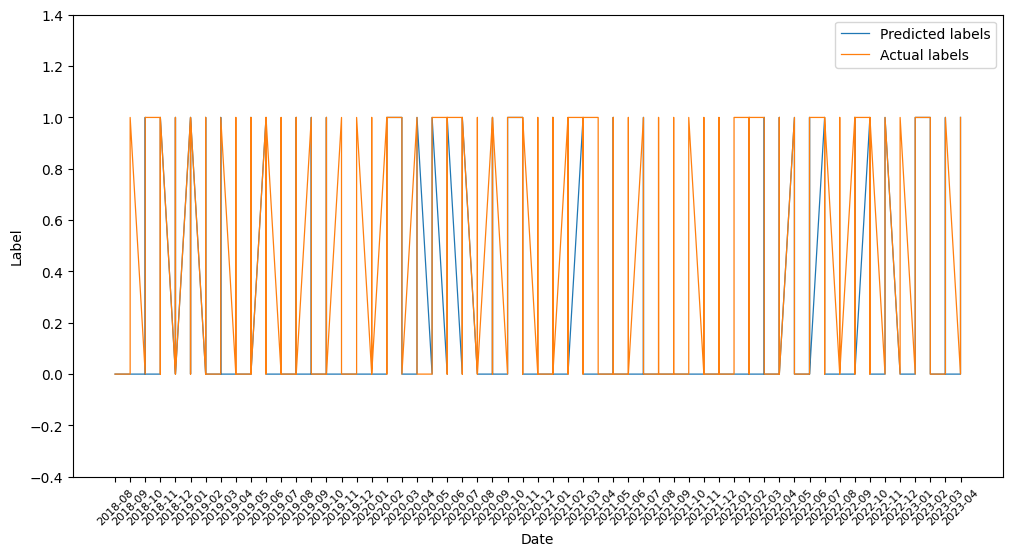

Current Trend Date
2023-05-03    0
2023-05-04    1
dtype: int64
Our Model Forecast [0 1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Date
2023-05-03    0
2023-05-04    1
dtype: int64 [0 1] ['2023-05-03', '2023-05-04']


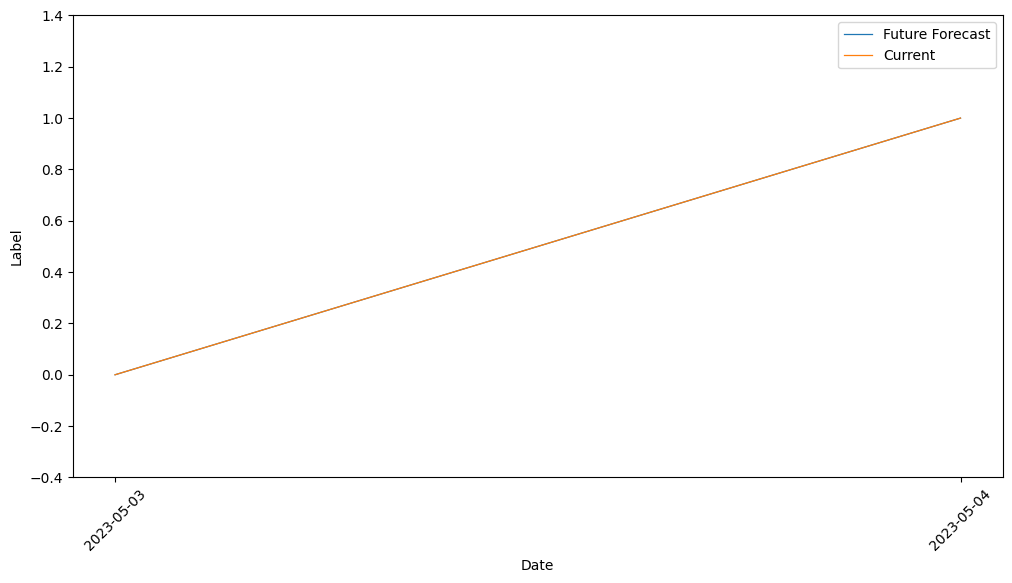

In [ ]:
# Get the last 20% of the data for future prediction
future_data = data.iloc[int(len(data)*0.8):, :]

# Define the date range for downloading future data
start_date_fut = '2023-05-01'
end_date_fut = '2023-05-06'

# Download the future data
future_data = yf.download(ticker_symbol, start=start_date_fut, end=end_date_fut)

# Calculate the returns and volatility for the future data
future_data['returns'] = future_data['Adj Close'].pct_change()
future_data['log_returns'] = np.log(1 + future_data['returns'])
future_data['volatility'] = future_data['log_returns'].rolling(window=3, min_periods=1).std() * np.sqrt(252)

# Drop any missing values from the future data
future_data.dropna(inplace=True)

# Prepare the input features for the future data
future_X = future_data[['Open', 'Close', 'High', 'Low', 'Volume', 'volatility']].values
future_X = scaler.transform(future_X)
future_X = np.reshape(future_X, (future_X.shape[0], future_X.shape[1], 1))

# Prepare the labels for the future data
future_y = ((future_data['High'].shift(-1) / future_data['Open']) >= 1.01).astype(int)
future_y = future_y[:-1]

# Generate predictions for the future data using the trained model
future_probs = model.predict(future_X)
future_forecast = np.argmax(future_probs, axis=1)

# Print the test dataset and the model's predictions
print("Test Dataset", y_test)
print("Our Model Forecast", predicted_labels)

# Generate and print the classification report for the test dataset
report = classification_report(y_test, predicted_labels_binary)
print(report)

# Plot the predicted labels and actual labels for the test dataset
plt.figure(figsize=(12, 6))
start = len(y_train)
end = len(y_train) + len(predicted_labels)
pred_dates = [date.strftime('%Y-%m') for date in data.index.date]
plt.plot(pred_dates[start:end], predicted_labels, linewidth=0.9, label='Predicted labels')
plt.plot(pred_dates[start:end], y_test, linewidth=0.9, label='Actual labels')

plt.ylim(-0.4, 1.4) 
plt.legend()
plt.xlabel('Date')
plt.ylabel('Label')
plt.xticks(rotation=45, fontsize=8)
plt.show()

# Plot the future forecast for unexplored days
plt.figure(figsize=(12, 6))
start = len(y_train) + len(y_test)
end = len(y_train) + len(y_test) + len(future_y)

# Print the current trend and the model's forecast
print("Current Trend", future_y)
print("Our Model Forecast", future_forecast[1:])

# Generate and print the classification report for the future data
report = classification_report(future_y, future_forecast[1:])
print(report)

# Plot the future forecast and current trend
future_dates = [date.strftime('%Y-%m-%d') for date in future_data.index.date]
plt.plot(future_dates[0:len(future_y)], future_forecast[1:], linewidth=0.9, label='Future Forecast')
plt.plot(future_dates[0:len(future_y)], future_y, linewidth=0.9, label='Current')

plt.ylim(-0.4, 1.4) 
plt.legend()
plt.xlabel('Date')
plt.ylabel('Label')
plt.xticks(rotation=45)
plt.show()

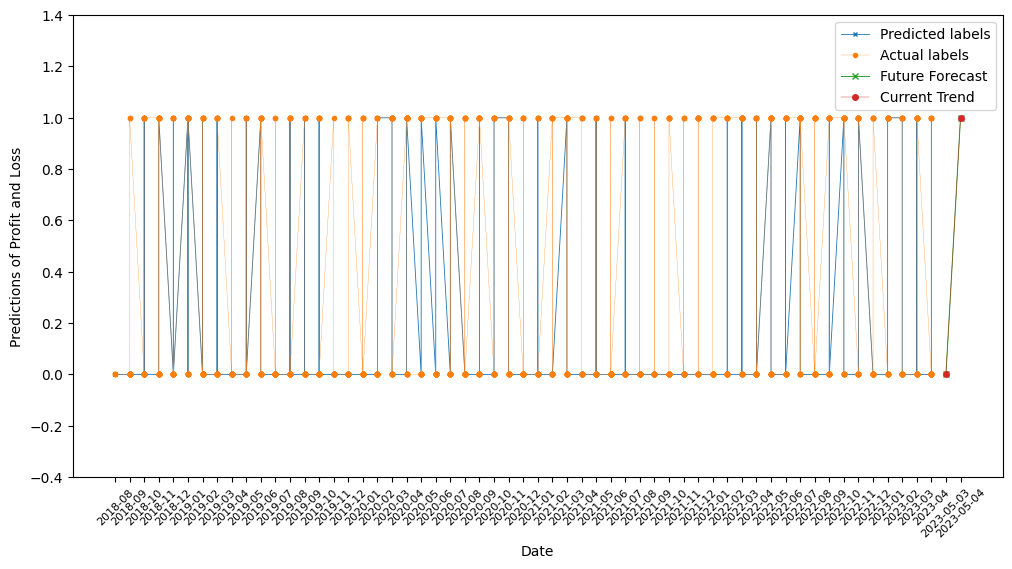

In [ ]:
# Create a figure with a specified size (12 x 6 inches)
plt.figure(figsize=(12, 6))

# Calculate the start and end indices for the test dataset
start = len(y_train)
end = len(y_train) + len(predicted_labels)

# Extract and format the dates from the data's index for the test dataset
pred_dates = [date.strftime('%Y-%m') for date in data.index.date]

# Plot the predicted labels for the test dataset
plt.plot(pred_dates[start:end], predicted_labels, marker='x', markersize=3, linewidth=0.6, label='Predicted labels')

# Plot the actual labels for the test dataset
plt.plot(pred_dates[start:end], y_test, marker='o', markersize=3, linewidth=0.2, label='Actual labels')

# Calculate the start and end indices for the future unexplored data
start = len(y_train) + len(y_test)
end = len(y_train) + len(y_test) + len(future_y)

# Extract and format the dates from the future_data's index
future_dates = [date.strftime('%Y-%m-%d') for date in future_data.index.date]

# Plot the future forecast
plt.plot(future_dates[0:len(future_y)], future_forecast[1:], marker='x', markersize=4, linewidth=0.7, label='Future Forecast')

# Plot the current trend
plt.plot(future_dates[0:len(future_y)], future_y, marker='o', markersize=4, linewidth=0.3, label='Current Trend')

# Set y-axis limits, add a legend, and label the x and y axes
plt.ylim(-0.4, 1.4) 
plt.legend()
plt.xlabel('Date')
plt.ylabel('Predictions of Profit and Loss')

# Format the x-axis tick labels
plt.xticks(rotation=45, fontsize=8)

# Display the combined plot
plt.show()

**Exploratory Data Analysis**

In [ ]:
# Download historical data for SPY from 2000 to 2023
df = yf.download('SPY', start='2000-01-01', end='2023-04-30')

# Calculate 1-year returns and market capitalization
df['1Y Returns'] = df['Adj Close'].pct_change(periods=252)
df['Market Cap'] = df['Close'] * df['Volume']

# Filter the data to only include records from 2022 onwards
df = df.loc['2022-01-01':]

# Create hover text for each data point, displaying date, market cap, and 1-year returns
hover_text = df.apply(lambda x: f"<b>Date:</b> {x.name.strftime('%Y-%m-%d')}<br><b>Market Cap:</b> ${x['Market Cap']:.2f}B<br><b>1Y Returns:</b> {x['1Y Returns']:.2%}", axis=1)

# Generate a scatter plot using Plotly Express
fig = px.scatter(df, x='Market Cap', y='1Y Returns', color='1Y Returns', size='Market Cap',
                 hover_name=df.index.date, hover_data={'Market Cap': True, '1Y Returns': ':.2%'},
                 labels={'Market Cap': 'Market Capitalization (Billions of Dollars)', '1Y Returns': '1-Year Returns'})

# Update plot layout with a title
fig.update_layout(title_text='SPDR S&P 500 ETF Trust Market Capitalization vs. 1-Year Returns (2000-2023)')

# Show the plot
fig.show()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

# Update the chart layout with a title and axis labels
fig.update_layout(title='SPY Candlestick Chart (2000-2023)',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

# Show the chart
fig.show()

In [ ]:
# Download historical data for SPY from 2000 to 2023
df = yf.download('SPY', start='2000-01-01', end='2023-04-30')

# Calculate daily returns
returns = df['Close'].pct_change()
returns.index = pd.to_datetime(returns.index)

# Create a heatmap of daily returns for each year and day of the week
returns_heatmap = pd.DataFrame(index=returns.index.day_name().unique(), columns=returns.index.year.unique())

for year in returns_heatmap.columns:
    for day in returns_heatmap.index:
        daily_returns = returns.loc[(returns.index.year == year) & (returns.index.day_name() == day)]
        returns_heatmap.loc[day, year] = daily_returns.mean()

returns_heatmap.index.name = 'Day of the week'
returns_heatmap.columns.name = 'Year'

# Generate a heatmap using Plotly Express
fig = px.imshow(returns_heatmap, color_continuous_scale='RdBu_r', title='Daily Returns Heatmap')

# Show the heatmap
fig.show()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Calculate daily volatility and volume
returns = df['Close'].pct_change()
volatility = returns.rolling(window=252).std() * (252**0.5)
volume = df['Volume']

# Create a heatmap of daily volatility for each year and day of the week
volatility_heatmap = pd.DataFrame(index=volatility.index.day_name().unique(), columns=volatility.index.year.unique())

for year in volatility_heatmap.columns:
    for day in volatility_heatmap.index:
        daily_volatility = volatility.loc[(volatility.index.year == year) & (volatility.index.day_name() == day)]
        volatility_heatmap.loc[day, year] = daily_volatility.mean()

volatility_heatmap.index.name = 'Day of the week'
volatility_heatmap.columns.name = 'Year'

# Generate a heatmap using Plotly Express
fig1 = px.imshow(volatility_heatmap, color_continuous_scale='RdBu_r', title='Daily Volatility Heatmap')

# Show the heatmap
fig1.show()

# Download historical data for SPY from 2000 to 2023
df = yf.download('SPY', start='2000-01-01', end='2023-04-30')

# Calculate daily returns and create a DataFrame with daily returns and volume
daily_returns = df['Close'].pct_change()
df_returns_volume = pd.DataFrame({
    'Returns': daily_returns,
    'Volume': df['Volume']
})

[*********************100%***********************]  1 of 1 completed


The report can be found in a different document for further analysis.